In [1]:
import operator
from typing import Callable, List

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
import pandas as pd

from data_utils import map_column_to_ints, concat_cols
from raw_dataset import RawDataset
from processed_dataset import ProcessedDataset
from split_dataset import SplitDataset
from nn_toolkit.vocab import Vocab, VocabBuilder

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
raw = RawDataset()
processed = ProcessedDataset(raw)
processed.process()
split_ds = SplitDataset(processed)

In [15]:
token_columns = ['raw_text_tokens', 'clean_text_tokens', 'location_tokens', 'keyword_tokens', 'hashtag_tokens']
concat_cols(split_ds, token_columns, 'tokens', '<sep>')

In [17]:
vocab = VocabBuilder(max_size=20000, min_count=2).from_df(
    split_ds.train_df, 'raw_text_tokens'
)
print(f'Vocab size: {vocab.size}')

Vocab size: 5896


In [18]:
split_ds.train_df['tokens']

1993    [reusing, advanced, in, life, equipments, in, ...
4749    [couple, storms, near, guthrie, ok, ., leaving...
2453    [<@user-handle>, i, know, the, cow, incident, ...
603     [fedex, no, longer, to, transport, bioterror, ...
1128    [storm, in, ri, worse, than, last, hurricane, ...
                              ...                        
6980    [just, stop, fucking, saying, , ûïa, whole, ...
4184    [get, that, hazard, pay, <sep>, <sep>, arizona...
5265    [<@user-handle>, can'twon't, tell, <@user-hand...
2990    [i'm, drowning, in, hw, now, and, that's, w, /...
900     [damn, bloody, hot, <sep>, <sep>, singapore, <...
Name: tokens, Length: 6090, dtype: object

In [19]:
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: [t if t in vocab else vocab.unk for t in x],
    preprocessor=lambda x: x,
    vocabulary=vocab.token_to_int
)

In [20]:
X_train = vectorizer.fit_transform(split_ds.train_df.tokens)
X_val = vectorizer.transform(split_ds.val_df.tokens)
X_test = vectorizer.transform(split_ds.test_df.tokens)

In [21]:
y_train = split_ds.train_df.target.values
y_val = split_ds.val_df.target.values

In [22]:
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    score = roc_auc_score(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.title(f'ROC AUC Score: {100 * score: 0.2f}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), 'k--')
    plt.show()

In [23]:
def sklearn_test_predictions(split_ds: SplitDataset, transforms, clf, test: bool = False):
    if test:
        train_df = pd.concat([split_ds.train_df, split_ds.val_df], sort=False)
        test_df = split_ds.test_df
    else:
        train_df = split_ds.train_df
        test_df = split_ds.val_df
    X_train = transforms.fit_transform(train_df.tokens)
    X_test = transforms.transform(test_df.tokens)
    y_train = train_df.target.values
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    if test:
        test_df['target'] = y_pred
        return test_df[['id', 'target']]
    else:
        y_proba = clf.predict_proba(X_test)[:, 1]
        y_test = test_df.target.values
        plot_roc_curve(y_test, y_proba)
        acc = accuracy_score(y_test, y_pred)
        print(f'Validation Accuracy: {100 * acc:0.2f}%')
        test_df['y_pred'] = y_pred
        test_df['y_proba'] = y_proba.tolist()
        return test_df

/home/mayen/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


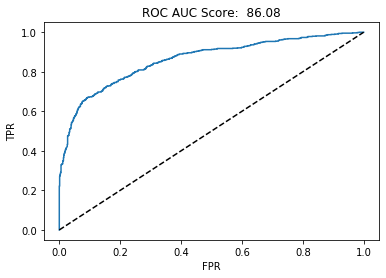

Validation Accuracy: 79.91%


In [24]:
_ = sklearn_test_predictions(split_ds, vectorizer, LogisticRegression(), test=False)

In [20]:
submission_df = sklearn_test_predictions(
    split_ds,
    vectorizer,
    LogisticRegression(),
    test=True
)
submission_df.to_csv('../data/submissions/sklearn_lr.csv', index=False)

/home/mayen/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


/home/mayen/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


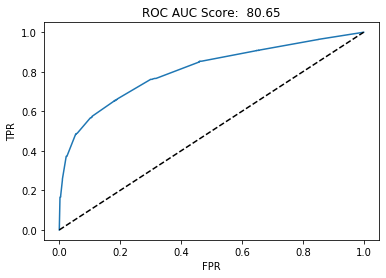

Validation Accuracy: 75.84%


In [21]:
submission_df = sklearn_test_predictions(
    split_ds,
    vectorizer,
    RandomForestClassifier(),
    test=False
)

In [181]:
submission_df = sklearn_test_predictions(
    split_ds,
    vectorizer,
    RandomForestClassifier(),
    test=True
)
submission_df.to_csv('../data/submissions/sklearn_rf.csv', index=False)